In [23]:
import numpy as np
import matplotlib.pyplot as plt
import math

Declarations

In [76]:
feasible = []
feasible_perfect = []  
potential = []
mu_th = 7
T = 100
i_star_t = 0
i_t = 0
x = 4
N = 3

### Oracle

In [79]:
class Oracle:
    def __init__(self, M, N):
        self.M = M
        self.N = N
        # currently N=3, M=2
        ## set the value of means
        self.mu_ij = [[0 for i in range(M)] for j in range(5)]
        ## have 5 arms in total
        # print(self.mu_ij.shape)
        self.var = 5
        

        # #### Case 1 #####
        # self.mu_ij[0] = np.array([7, 8])   #15
        # self.mu_ij[1] = np.array([4, 6])    #14
        # self.mu_ij[2] = np.array([11, 4])    #11
        # self.mu_ij[3] = np.array([4, 8])    #12
        # self.mu_ij[4] = np.array([1, 7])    #8
        # #################

        #### Case 2 #####
        self.mu_ij[0] = np.array([20, 10])     #30    
        self.mu_ij[1] = np.array([x, 30-x])    #12 to 28
        self.mu_ij[2] = np.array([10, 10])     #10
        self.mu_ij[3] = np.array([5, 10])    #15
        self.mu_ij[4] = np.array([7, 10])   #17
        #################
        # print(self.mu_ij)


    def play(self, arm):
        reward = np.zeros(self.M, dtype=int)
        for j in range (len(reward)):
            reward[j] = np.random.normal(self.mu_ij[arm][j], self.var, 1)
        return reward

### Functions required

In [14]:
def get_margins(mu, N, t, T):
    delta = 0.1
    val1 = 2*N/delta
    val2 = t**4
    val = val1*val2
    # print(val)
    log_term = math.log(val)
    sqrt_term = log_term/2/T
    alpha = math.sqrt(sqrt_term)
    LCB = mu - alpha
    UCB = mu + alpha
    return LCB, UCB

In [15]:
def get_feasible_set(mu_th, UCB_attr):
    ## mu_attr will be an array with the current means of all attributes of the specific arm
    ## same for UCB and LCB things
    feasible_set = []
    ## here mu_attr would be a 2D array with all the means
    ## same for LCB (LCB_attr)
    n = len(UCB_attr)
    m = len(UCB_attr[0])
    for i in range (n):
        ## for each arm
        found = False
        for j in range(m):
            if(UCB_attr[i][j] >= mu_th):
                found = True
                continue
            else:
                found = False
                break
        if (found == True):
            feasible_set.append(i)

    return feasible_set

In [16]:
def get_perfect_feasible_set(mu_th, LCB_attr):
    feasible_set = []
    ## here mu_attr would be a 2D array with all the means
    ## same for LCB (LCB_attr)
    n = len(LCB_attr)
    m = len(LCB_attr[0])
    for i in range (n):
        ## for each arm
        found = False
        for j in range(m):
            if(LCB_attr[i][j] >= mu_th):
                found = True
                continue
            else:
                found = False
                break
        if (found == True):
            feasible_set.append(i)

    return feasible_set

In [17]:
def get_potential_set(i_star_t, LCB_i_star, UCB):
    ## here UCB will be an array for UCB of means of all the arms
    potent = []
    # print(LCB_i_star)
    # print(UCB)
    for i in range(len(UCB)):
        if ((LCB_i_star <= UCB[i]) and (i != i_star_t)):
        # if(LCB_i_star <= UCB[i]):
            potent.append(i)
    # print("potent", potent)
    return potent

In [18]:
def best_arm(mu, feasible_set):
    ## for arms in feasible set, we need to find the arm with maximum mean
    # print(feasible_set)
    best = feasible_set[0]
    for i in range (len(feasible_set)):
        if (mu[feasible_set[i]] > mu[best]):
            # print(feasible_set)
            best = feasible_set[i]

    return best

In [19]:
def potentially_competitor_arm(UCB, feasible_set, potentially_best_arm):
    # best = feasible_set[0]
    # print(UCB)
    if (potentially_best_arm != feasible_set[0]):
        best = feasible_set[0]
    else:
        best = feasible_set[1]
    # print(feasible_set[1])
    # print(best)
    for arm in feasible_set:
        if (arm != potentially_best_arm):
            if((UCB[arm] > UCB[best])):
                best = arm
    # print("pot: ", potentially_best_arm, "ct: ", best)
    return best

In [20]:
def intersection(lst1, lst2):
    temp = set(lst2)
    lst3 = [value for value in lst1 if value in temp]
    return lst3

### Main loop

In [21]:
def game():
    n_samples = 0
    N = 3                                                                   # Number of arms
    M = 2                                                                   # Number of attributes
    theGame = Oracle(M, N)
    mu_hat_i = [0]*N                                                        # Arm wise mean
    mu_hat_ij = [[0 for i in range(M)] for j in range(N)]                #np.zeros((M, N))  #[[0 for i in range(M)] for j in range(N)]   #[[0]*M]*N                                                    # Attribute wise means
    n_plays = [0]*N
    LCB = [0]*N
    UCB = [0]*N
    LCB_attr = [[0 for i in range(M)] for j in range(N)]
    UCB_attr = [[0 for i in range(M)] for j in range(N)]
    
    ## Uniform exploration
    T_unif = 20
    for j in range (T_unif):
        for i in range (N):
            reward_arm = theGame.play(i)
            n_plays[i] += 1
            mu_hat_ij[i] = (mu_hat_ij[i] * n_plays[i] + reward_arm)/(n_plays[i] + 1)
            mu_hat_i[i] = sum(mu_hat_ij[i])

    feasible = list(range(0, N))
    n_samples += N*T_unif

    ## further pulls
    t = 1
    i_star_t = 0
    i_t = 0

    while(True):
        # print(mu_hat_ij)
        # print(feasible_perfect)
        ## arm wise margins
        for i in range (N):
            LCB[i], UCB[i] = get_margins(mu_hat_i[i], N, t, n_plays[i])

        ## attribute wise margins
        for i in range (N):
            for j in range (M):
                LCB_attr[i][j], UCB_attr[i][j] = get_margins(mu_hat_ij[i][j], N, t, T)

        feasible_perfect = get_perfect_feasible_set(mu_th, LCB_attr)
        feasible = get_feasible_set(mu_th, UCB_attr)
        ## update feasible sets here

        if(len(feasible_perfect) != 0):
            i_star_t = best_arm(mu_hat_i, feasible_perfect)
            # print(i_star_t)

        if (len(feasible) != 0):
            i_t = best_arm(mu_hat_i, feasible)
        

        potential = get_potential_set(i_star_t, LCB[i_star_t], UCB)

        pot_intersect_feas = intersection(potential, feasible)

        # print("Feasible: ", feasible, "Perfect feasible: ", feasible_perfect, "Potential: ", potential, "i_t: ", i_t, "i_star: ", i_star_t, "mu_hat for all", mu_hat_i, "LCB of i_star: ", LCB[i_star_t], "UCB of all: ", UCB)
        # print(UCB_attr)

        if (len(pot_intersect_feas) == 0):
            # print("intersection empty")
            # i_out = i_star_t
            # return i_out, n_samples
            if (len(feasible) == 0):
                i_out = N
                f_hat = 0
                # print("Wrong")
            else:
                f_hat = 0
                # print("Change i_t")
                i_out = i_t
                # i_t = best_arm(mu_hat_i, feasible)
            return i_out, n_samples
                #break

        if (len(feasible) == 1):
            # print("aa")
            i_t = best_arm(mu_hat_i, feasible)
            arm_next1 = i_t
            arm_next2 = i_t                  ################## UPDATE ######something from infeasible set
        else:
            # print("bb")
            arm_next1 = i_t
            i_t = best_arm(mu_hat_i, feasible)
            c_t = potentially_competitor_arm(UCB, feasible, i_t)
            arm_next2 = c_t

        reward_arm1 = theGame.play(arm_next1)
        reward_arm2 = theGame.play(arm_next2)
        n_samples += 2
        # print("cc")

        mu_hat_ij[arm_next1] = (mu_hat_ij[arm_next1] * n_plays[arm_next1] + reward_arm1)/(n_plays[arm_next1] + 1)
        mu_hat_ij[arm_next2] = (mu_hat_ij[arm_next2] * n_plays[arm_next2] + reward_arm2)/(n_plays[arm_next2] + 1)
        mu_hat_i[arm_next1] = sum(mu_hat_ij[arm_next1])
        mu_hat_i[arm_next2] = sum(mu_hat_ij[arm_next2])
        n_plays[arm_next1] += 1
        n_plays[arm_next2] += 2

        # print(i_star_t)
        
        t += 1

### Case 1
The case where means are much higher than the threshold value, and the means of two arms (0 and 1) are close enough
[8, 7]
[8, 6]
[5, 6]
Var = 2

In [136]:
best_arm_identified = []
N_iter = 1000
for i in range (N_iter):
    best_arm_guess, samples = game()
    best_arm_identified.append(best_arm_guess)
prob0 = best_arm_identified.count(0)/N_iter
prob1 = best_arm_identified.count(1)/N_iter
prob2 = best_arm_identified.count(2)/N_iter
prob_wrong = best_arm_identified.count(3)/N_iter
print(prob0, prob1, prob2, prob_wrong)

# best_arm_identified, samples = game()
# print(best_arm_identified)

0.909 0.091 0.0 0.0


### Case 2


[6, 4], [7, 6], [11, 4], threshold = 5

In [183]:
best_arm_identified = []
N_iter = 1000
for i in range (N_iter):
    best_arm_guess, samples = game()
    best_arm_identified.append(best_arm_guess)
prob0 = best_arm_identified.count(0)/N_iter
prob1 = best_arm_identified.count(1)/N_iter
prob2 = best_arm_identified.count(2)/N_iter
prob_wrong = best_arm_identified.count(3)/N_iter
print(prob0, prob1, prob2, prob_wrong)

# best_arm_identified, samples = game()
# print(best_arm_identified)

Feasible:  [1] Perfect feasible:  [] Potential:  [1, 2] i_t:  1 i_star:  0 mu_hat for all [8.238095238095237, 11.38095238095238, 13.238095238095237] LCB of i_star:  8.09501580976569 UCB of all:  [8.381174666424785, 11.524031809281928, 13.381174666424785]
Feasible:  [1] Perfect feasible:  [] Potential:  [1, 2] i_t:  1 i_star:  0 mu_hat for all [8.238095238095237, 11.626714177734588, 13.238095238095237] LCB of i_star:  8.052799079413225 UCB of all:  [8.42339139677725, 11.8120103364166, 13.42339139677725]
Feasible:  [1] Perfect feasible:  [] Potential:  [1, 2] i_t:  1 i_star:  0 mu_hat for all [8.238095238095237, 11.695367708370828, 13.238095238095237] LCB of i_star:  8.032075897778672 UCB of all:  [8.444114578411803, 11.901387048687393, 13.444114578411803]
Feasible:  [1] Perfect feasible:  [1] Potential:  [2] i_t:  1 i_star:  1 mu_hat for all [8.238095238095237, 11.75592396551259, 13.238095238095237] LCB of i_star:  11.536384424578598 UCB of all:  [8.45763477902923, 11.975463506446582, 1

### Case 3
[10, 3], [3, 9], [5, 5], threshold = 4

In [191]:
best_arm_identified = []
N_iter = 5000
for i in range (N_iter):
    best_arm_guess, samples = game()
    best_arm_identified.append(best_arm_guess)
prob0 = best_arm_identified.count(0)/N_iter
prob1 = best_arm_identified.count(1)/N_iter
prob2 = best_arm_identified.count(2)/N_iter
prob_wrong = best_arm_identified.count(3)/N_iter
print(prob0, prob1, prob2, prob_wrong)

# best_arm_identified, samples = game()
# print(best_arm_identified)

Feasible:  [2] Perfect feasible:  [] Potential:  [] i_t:  2 i_star:  0 mu_hat for all [11.857142857142858, 6.6190476190476195, 8.380952380952381] LCB of i_star:  11.71406342881331 UCB of all:  [12.000222285472406, 6.762127047377168, 8.52403180928193]
Feasible:  [2] Perfect feasible:  [2] Potential:  [0] i_t:  2 i_star:  2 mu_hat for all [11.523809523809524, 7.380952380952381, 8.714285714285715] LCB of i_star:  8.571206285956167 UCB of all:  [11.666888952139072, 7.52403180928193, 8.857365142615263]
Feasible:  [2] Perfect feasible:  [] Potential:  [] i_t:  2 i_star:  0 mu_hat for all [11.333333333333334, 6.238095238095238, 8.476190476190476] LCB of i_star:  11.190253905003786 UCB of all:  [11.476412761662882, 6.381174666424787, 8.619269904520024]
Feasible:  [2] Perfect feasible:  [] Potential:  [] i_t:  2 i_star:  0 mu_hat for all [11.666666666666666, 6.142857142857142, 8.333333333333332] LCB of i_star:  11.523587238337118 UCB of all:  [11.809746094996214, 6.285936571186691, 8.4764127616

### Case 4

In [376]:
best_arm_identified = []
N_iter = 5000
for i in range (N_iter):
    best_arm_guess, samples = game()
    best_arm_identified.append(best_arm_guess)
prob0 = best_arm_identified.count(0)/N_iter
prob1 = best_arm_identified.count(1)/N_iter
prob2 = best_arm_identified.count(2)/N_iter
print(prob0, prob1, prob2)

# best_arm_identified, samples = game()
# print(best_arm_identified)

0.0622 0.9278 0.01


### Both arms valid, taking mean of one closer to the other
[20, 10], [x, 13], [5, 6], threshold = 2, var=3
x varies from 4 to 16

In [72]:
### means in oracle
# self.mu_ij[0] = np.array([20, 10])   #30
# self.mu_ij[1] = np.array([x, 13])    #12 to 28
# self.mu_ij[2] = np.array([5, 6])    #10
N = 3
x = 4
N_iter = 1000

prob_correct = []
prob_giveup = []
sample_req = []
x_val = []

while(x < 17):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    for i in range (N_iter):
        best_arm_guess, samples = game()
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)
    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct.append(prob0)
    prob_giveup.append(probN)
    sample_req.append(samp_avg)

    x += 1

print(prob_correct)
print(prob_giveup)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.992, 0.913]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


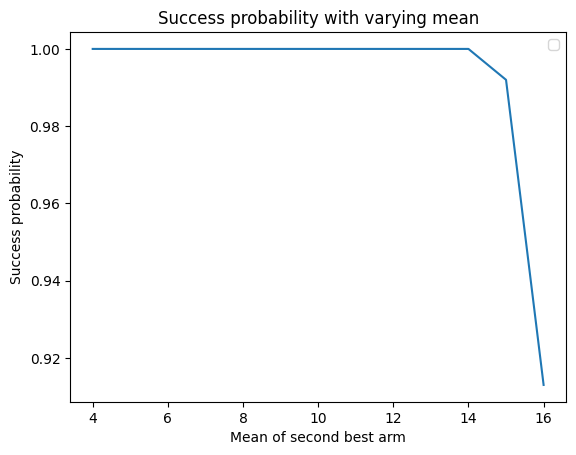

In [73]:
plt.title("Success probability with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Success probability")
plt.plot(x_val, prob_correct)
plt.legend()
plt.show()

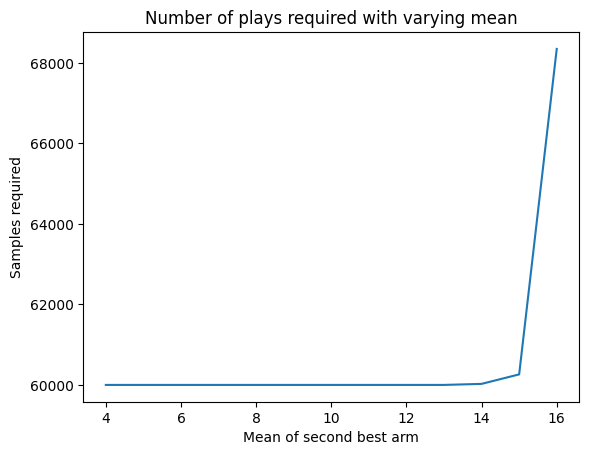

In [74]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Samples required")
plt.plot(x_val, sample_req)
plt.show()

### Case
Best and second best arm (arm 0 and arm 1) have same total mean, one of them (arm 0) violates the threshold, we will take one attribute of arm 0 closer to the threshold and compare the results

[10, 20], [x, 30-x], [10, 10], threshold = 7, x varies from 1 to 7, var = 4

In [84]:
### means in oracle
# self.mu_ij[0] = np.array([20, 10])     #30
# self.mu_ij[1] = np.array([x, 30-x])    #12 to 28
# self.mu_ij[2] = np.array([10, 10])     #10

x = 1
N_iter = 1000
N = 3

prob_correct = []
sample_req = []
x_val = []

while(x < 7):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    for i in range (N_iter):
        best_arm_guess, samples = game()
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)
    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct.append(prob0)
    prob_giveup.append(probN)
    sample_req.append(samp_avg)

    x += 1
    print(prob0)

# print(prob_giveup)


0.985
0.983
0.979
0.977
0.979
0.94


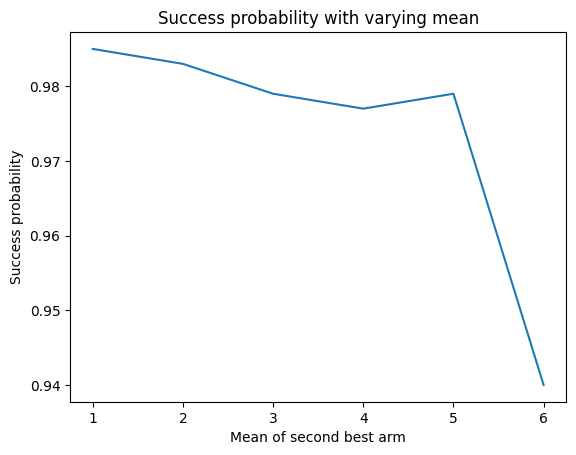

In [86]:
plt.title("Success probability with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Success probability")
plt.plot(x_val, prob_correct)
plt.show()

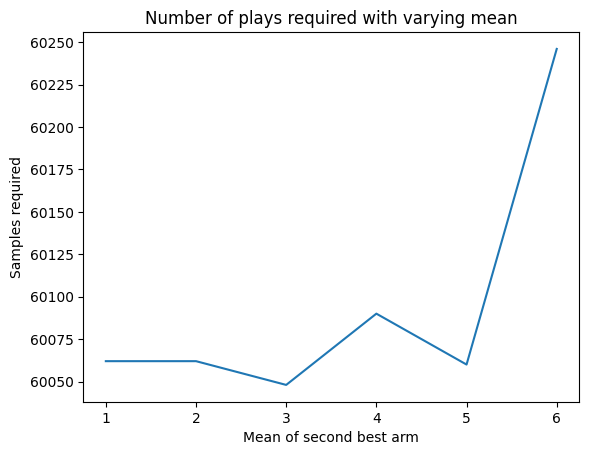

In [83]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Samples required")
plt.plot(x_val, sample_req)
plt.show()

### Case
Arm 1 violates the threshold but it has the maximum mean. Arm 0 has 2nd maximum mean but both the arms are valid. We will increase the mean of this arm to that of arm 0 and check the probability of success (predicting arm 0)

In [267]:
# self.mu_ij[0] = np.array([x, 8])     #15 (move from 15 to 23) - x from 7 to 15
# self.mu_ij[1] = np.array([5, 16])    #21
# self.mu_ij[2] = np.array([7, 8])     #15
# threshold = 6
# var = 2
# prob of success should improve with time

x = 8
N_iter = 5000

prob_correct = []
prob_giveup = []
sample_req = []
x_val = []

while(x < 16):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    for i in range (N_iter):
        best_arm_guess, samples = game()
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)
    prob0 = best_arm_identified.count(0)/N_iter
    prob1 = best_arm_identified.count(1)/N_iter
    prob2 = best_arm_identified.count(2)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct.append(prob0)
    prob_giveup.append(probN)
    sample_req.append(samp_avg)

    x += 1
    print(prob0, prob1, prob2, probN)

0.921 0.0 0.079 0.0
0.993 0.0 0.007 0.0
0.999 0.0 0.0006 0.0004
0.9992 0.0 0.0008 0.0
0.9988 0.0002 0.0008 0.0002
0.9986 0.0 0.0014 0.0
0.9984 0.0 0.0014 0.0002
0.9978 0.0 0.002 0.0002


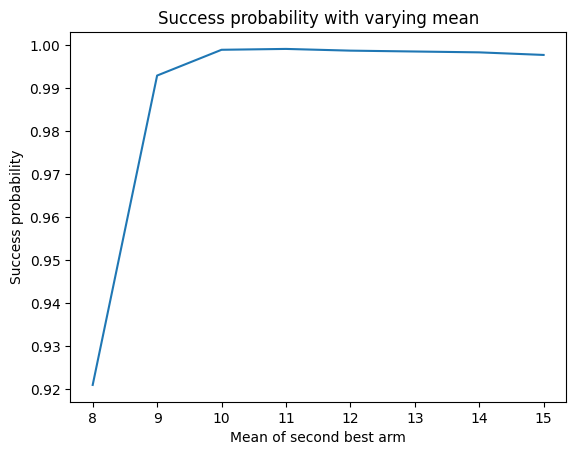

In [268]:
plt.title("Success probability with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Success probability")
plt.plot(x_val, prob_correct)
plt.show()

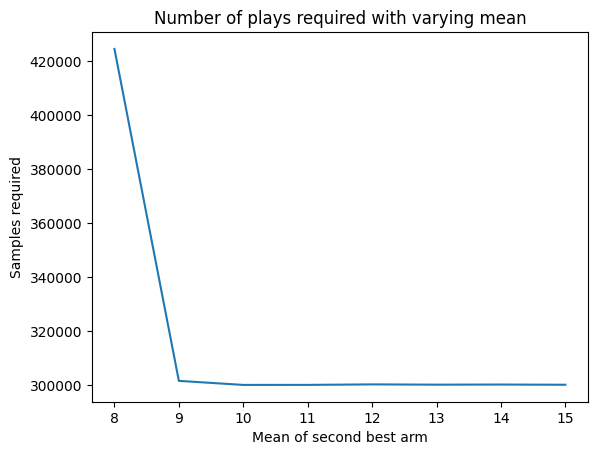

In [269]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Samples required")
plt.plot(x_val, sample_req)
plt.show()

# For 5 arms

## Case 1

In [24]:
# self.mu_ij[0] = np.array([8, 7])   #15
#         self.mu_ij[1] = np.array([8, 6])    #14
#         self.mu_ij[2] = np.array([5, 6])    #11
#         self.mu_ij[3] = np.array([4, 8])    #12
#         self.mu_ij[4] = np.array([1, 7])    #8

N = 3
best_arm_identified_3 = []
N_iter = 1000
for i in range (N_iter):
    best_arm_guess, samples = game()
    best_arm_identified_3.append(best_arm_guess)
prob0 = best_arm_identified_3.count(0)/N_iter
prob1 = best_arm_identified_3.count(1)/N_iter
prob2 = best_arm_identified_3.count(2)/N_iter
prob_wrong = best_arm_identified_3.count(N)/N_iter
print(prob0, prob1, prob2, prob_wrong)


N = 4
best_arm_identified_4 = []
N_iter = 1000
for i in range (N_iter):
    best_arm_guess, samples = game()
    best_arm_identified_4.append(best_arm_guess)
prob0 = best_arm_identified_4.count(0)/N_iter
prob1 = best_arm_identified_4.count(1)/N_iter
prob2 = best_arm_identified_4.count(2)/N_iter
prob_wrong = best_arm_identified_4.count(N)/N_iter
print(prob0, prob1, prob2, prob_wrong)


N = 5
best_arm_identified_5 = []
N_iter = 1000
for i in range (N_iter):
    best_arm_guess, samples = game()
    best_arm_identified_5.append(best_arm_guess)
prob0 = best_arm_identified_5.count(0)/N_iter
prob1 = best_arm_identified_5.count(1)/N_iter
prob2 = best_arm_identified_5.count(2)/N_iter
prob_wrong = best_arm_identified_5.count(N)/N_iter
print(prob0, prob1, prob2, prob_wrong)

# best_arm_identified, samples = game()
# print(best_arm_identified)

0.901 0.099 0.0 0.0
0.908 0.092 0.0 0.0
0.905 0.095 0.0 0.0


## Case2

In [29]:
# self.mu_ij[0] = np.array([7, 8])   #15
#         self.mu_ij[1] = np.array([4, 6])    #14
#         self.mu_ij[2] = np.array([11, 4])    #11
#         self.mu_ij[3] = np.array([4, 8])    #12
#         self.mu_ij[4] = np.array([1, 7])    #8

N = 3
best_arm_identified_3 = []
N_iter = 1000
for i in range (N_iter):
    best_arm_guess, samples = game()
    best_arm_identified_3.append(best_arm_guess)
prob0 = best_arm_identified_3.count(0)/N_iter
prob1 = best_arm_identified_3.count(1)/N_iter
prob2 = best_arm_identified_3.count(2)/N_iter
prob_wrong = best_arm_identified_3.count(N)/N_iter
print(prob0, prob1, prob2, prob_wrong)


N = 4
best_arm_identified_4 = []
N_iter = 1000
for i in range (N_iter):
    best_arm_guess, samples = game()
    best_arm_identified_4.append(best_arm_guess)
prob0 = best_arm_identified_4.count(0)/N_iter
prob1 = best_arm_identified_4.count(1)/N_iter
prob2 = best_arm_identified_4.count(2)/N_iter
prob_wrong = best_arm_identified_4.count(N)/N_iter
print(prob0, prob1, prob2, prob_wrong)


N = 5
best_arm_identified_5 = []
N_iter = 1000
for i in range (N_iter):
    best_arm_guess, samples = game()
    best_arm_identified_5.append(best_arm_guess)
prob0 = best_arm_identified_5.count(0)/N_iter
prob1 = best_arm_identified_5.count(1)/N_iter
prob2 = best_arm_identified_5.count(2)/N_iter
prob_wrong = best_arm_identified_5.count(N)/N_iter
print(prob0, prob1, prob2, prob_wrong)

# best_arm_identified, samples = game()
# print(best_arm_identified)

1.0 0.0 0.0 0.0
1.0 0.0 0.0 0.0
0.998 0.0 0.0 0.0


## Case: all arms valid, taking mean of one arm closer to the next arm

In [ ]:
# self.mu_ij[0] = np.array([20, 10])     #16 (move from 15 to 21) - x from 7 to 13
#         self.mu_ij[1] = np.array([x, 13])    #21
#         self.mu_ij[2] = np.array([5, 6])     #11
#         self.mu_ij[3] = np.array([7, 8])
#         self.mu_ij[4] = np.array([9, 11])

In [38]:
N = 3
x = 4
N_iter = 1000

prob_correct_3 = []
prob_giveup_3 = []
sample_req_3 = []
x_val = []

while(x < 17):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    for i in range (N_iter):
        best_arm_guess, samples = game()
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)
    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct_3.append(prob0)
    prob_giveup_3.append(probN)
    sample_req_3.append(samp_avg)

    x += 1

print(prob_correct_3)
print(prob_giveup_3)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.994, 0.904]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [39]:
N = 4
x = 4
N_iter = 1000

prob_correct_4 = []
prob_giveup_4 = []
sample_req_4 = []
x_val = []

while(x < 17):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    for i in range (N_iter):
        best_arm_guess, samples = game()
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)
    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct_4.append(prob0)
    prob_giveup_4.append(probN)
    sample_req_4.append(samp_avg)

    x += 1

print(prob_correct_4)
print(prob_giveup_4)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.996, 0.897]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [40]:
N = 5
x = 4
N_iter = 1000

prob_correct_5 = []
prob_giveup_5 = []
sample_req_5 = []
x_val = []

while(x < 17):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    for i in range (N_iter):
        best_arm_guess, samples = game()
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)
    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct_5.append(prob0)
    prob_giveup_5.append(probN)
    sample_req_5.append(samp_avg)

    x += 1

print(prob_correct_5)
print(prob_giveup_5)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.993, 0.908]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


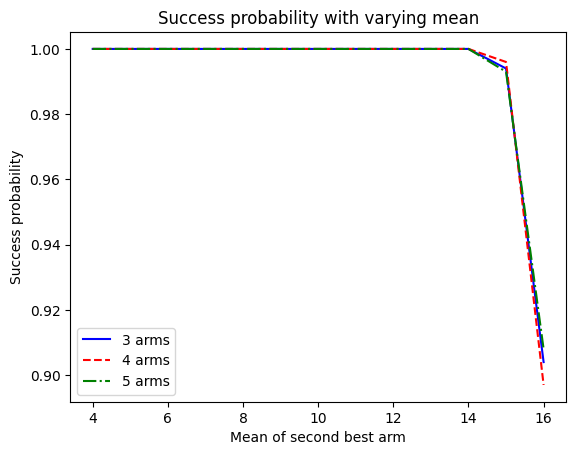

In [43]:
plt.title("Success probability with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Success probability")
plt.plot(x_val, prob_correct_3, label='3 arms', linestyle='-', color='blue')

# Plot the second graph
plt.plot(x_val, prob_correct_4, label='4 arms', linestyle='--', color='red')

# Plot the third graph
plt.plot(x_val, prob_correct_5, label='5 arms', linestyle='-.', color='green')
plt.legend()
plt.show()

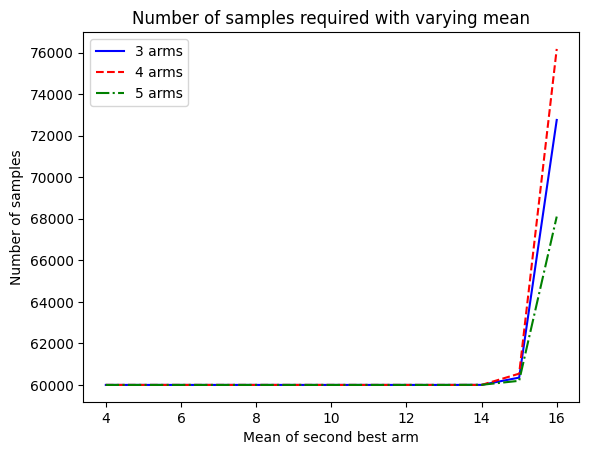

In [47]:
plt.title("Number of samples required with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Number of samples")
plt.plot(x_val, sample_req_3, label='3 arms', linestyle='-', color='blue')

# Plot the second graph
plt.plot(x_val, sample_req_4, label='4 arms', linestyle='--', color='red')

# Plot the third graph
plt.plot(x_val, sample_req_5, label='5 arms', linestyle='-.', color='green')
plt.legend()
plt.show()

## Case: 2 arms with same mean, but one of them violates threshold

In [ ]:
# self.mu_ij[0] = np.array([20, 10])     #16 (move from 15 to 21) - x from 7 to 13
#         self.mu_ij[1] = np.array([x, 30-x])    #21
#         self.mu_ij[2] = np.array([10, 10])     #11
#         self.mu_ij[3] = np.array([5, 20])
#         self.mu_ij[4] = np.array([7, 15])
# var = 5

In [55]:
N = 3
x = 1
N_iter = 1000

prob_correct_3 = []
prob_giveup_3 = []
sample_req_3 = []
x_val = []

while(x < 7):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    for i in range (N_iter):
        best_arm_guess, samples = game()
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)
    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct_3.append(prob0)
    prob_giveup_3.append(probN)
    sample_req_3.append(samp_avg)

    x += 1

print(prob_correct_3)
print(prob_giveup_3)

[0.98, 0.989, 0.977, 0.975, 0.977, 0.933]
[0.0, 0.0, 0.001, 0.0, 0.001, 0.002]


In [56]:
N = 4
x = 1
N_iter = 1000

prob_correct_4 = []
prob_giveup_4 = []
sample_req_4 = []
x_val = []

while(x < 7):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    for i in range (N_iter):
        best_arm_guess, samples = game()
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)
    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct_4.append(prob0)
    prob_giveup_4.append(probN)
    sample_req_4.append(samp_avg)

    x += 1

print(prob_correct_4)
print(prob_giveup_4)

[0.984, 0.975, 0.978, 0.983, 0.979, 0.938]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [57]:
N = 5
x = 1
N_iter = 1000

prob_correct_5 = []
prob_giveup_5 = []
sample_req_5 = []
x_val = []

while(x < 7):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    for i in range (N_iter):
        best_arm_guess, samples = game()
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)
    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct_5.append(prob0)
    prob_giveup_5.append(probN)
    sample_req_5.append(samp_avg)

    x += 1

print(prob_correct_5)
print(prob_giveup_5)

[0.981, 0.979, 0.974, 0.976, 0.972, 0.938]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


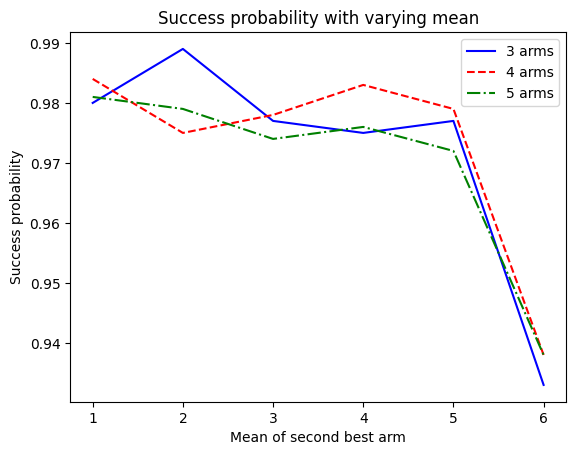

In [58]:
plt.title("Success probability with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Success probability")
plt.plot(x_val, prob_correct_3, label='3 arms', linestyle='-', color='blue')

# Plot the second graph
plt.plot(x_val, prob_correct_4, label='4 arms', linestyle='--', color='red')

# Plot the third graph
plt.plot(x_val, prob_correct_5, label='5 arms', linestyle='-.', color='green')
plt.legend()
plt.show()

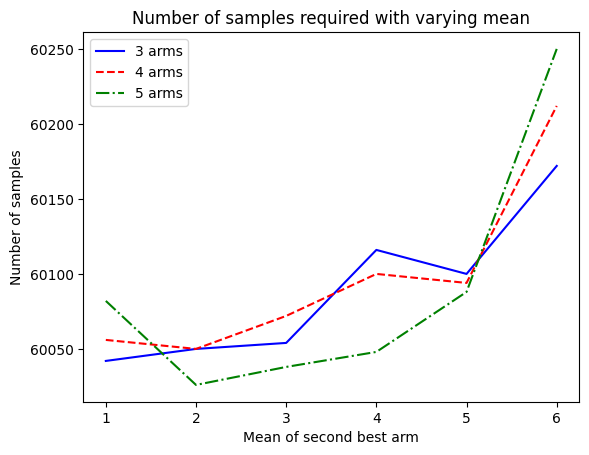

In [59]:
plt.title("Number of samples required with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Number of samples")
plt.plot(x_val, sample_req_3, label='3 arms', linestyle='-', color='blue')

# Plot the second graph
plt.plot(x_val, sample_req_4, label='4 arms', linestyle='--', color='red')

# Plot the third graph
plt.plot(x_val, sample_req_5, label='5 arms', linestyle='-.', color='green')
plt.legend()
plt.show()

## Case: Max mean arm violates the threshold, arm with 2nd max mean is valid

In [ ]:
# self.mu_ij[0] = np.array([x, 8])     #16 (move from 16 to 21) - x from 7 to 13
#         self.mu_ij[1] = np.array([5, 16])    #21
#         self.mu_ij[2] = np.array([7, 8])     #11
#         self.mu_ij[3] = np.array([5, 10])    #15
#         self.mu_ij[4] = np.array([7, 10])   #17
# th = 6
# var = 2

In [63]:
N = 3
x = 8
N_iter = 1000

prob_correct_3 = []
prob_giveup_3 = []
sample_req_3 = []
x_val = []

while(x < 16):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    for i in range (N_iter):
        best_arm_guess, samples = game()
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)
    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct_3.append(prob0)
    prob_giveup_3.append(probN)
    sample_req_3.append(samp_avg)

    x += 1

print(prob_correct_3)
print(prob_giveup_3)

[0.919, 0.994, 0.999, 0.999, 1.0, 0.998, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [64]:
N = 4
x = 8
N_iter = 1000

prob_correct_4 = []
prob_giveup_4 = []
sample_req_4 = []
x_val = []

while(x < 16):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    for i in range (N_iter):
        best_arm_guess, samples = game()
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)
    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct_4.append(prob0)
    prob_giveup_4.append(probN)
    sample_req_4.append(samp_avg)

    x += 1

print(prob_correct_4)
print(prob_giveup_4)

[0.922, 0.991, 0.998, 1.0, 0.997, 0.998, 1.0, 0.999]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [65]:
N = 5
x = 8
N_iter = 1000

prob_correct_5 = []
prob_giveup_5 = []
sample_req_5 = []
x_val = []

while(x < 16):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    for i in range (N_iter):
        best_arm_guess, samples = game()
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)
    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct_5.append(prob0)
    prob_giveup_5.append(probN)
    sample_req_5.append(samp_avg)

    x += 1

print(prob_correct_5)
print(prob_giveup_5)

[0.926, 0.991, 0.997, 0.999, 0.998, 1.0, 0.999, 0.999]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


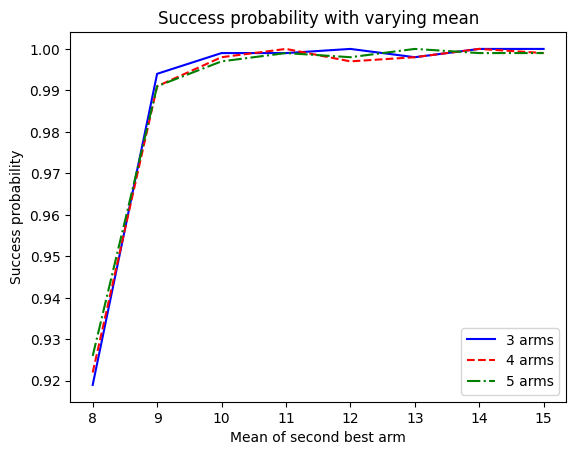

In [66]:
plt.title("Success probability with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Success probability")
plt.plot(x_val, prob_correct_3, label='3 arms', linestyle='-', color='blue')

# Plot the second graph
plt.plot(x_val, prob_correct_4, label='4 arms', linestyle='--', color='red')

# Plot the third graph
plt.plot(x_val, prob_correct_5, label='5 arms', linestyle='-.', color='green')
plt.legend()
plt.show()

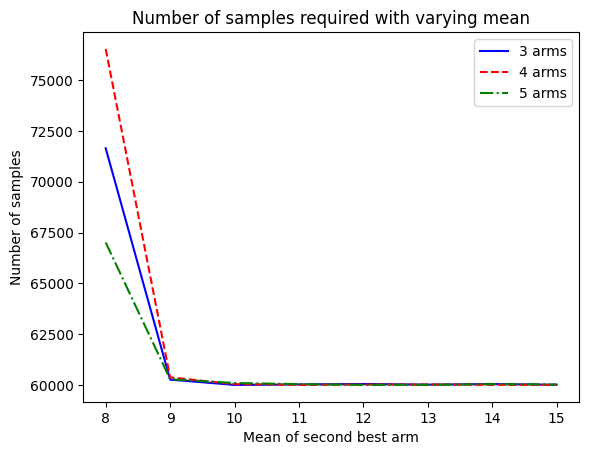

In [67]:
plt.title("Number of samples required with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Number of samples")
plt.plot(x_val, sample_req_3, label='3 arms', linestyle='-', color='blue')

# Plot the second graph
plt.plot(x_val, sample_req_4, label='4 arms', linestyle='--', color='red')

# Plot the third graph
plt.plot(x_val, sample_req_5, label='5 arms', linestyle='-.', color='green')
plt.legend()
plt.show()